This file imports ROOT data file (already added the four branches for study: chi, delta eta, delta phi, and Mjj) and provides a function to sort the process types for each collision. These are then plotted below.

In [7]:
import ROOT
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to convert ROOT histogram to numpy arrays
def root_hist_to_numpy(h, normalize=False):
    edges = np.array([h.GetBinLowEdge(i+1) for i in range(h.GetNbinsX()+1)])
    values = np.array([h.GetBinContent(i+1) for i in range(h.GetNbinsX())])
    if normalize and values.sum() > 0:
        values = values / values.sum()
    return edges, values

fileName = "/eos/user/k/kmonagha/dijet_events_data/SM_events/dijet_events_full_2000_2447.root"
treeName = "dijets"
d = ROOT.RDataFrame(treeName, fileName)

In [8]:
ROOT.gInterpreter.Declare("""
float ComputeJetGirth(
    const ROOT::VecOps::RVec<float>& px,
    const ROOT::VecOps::RVec<float>& py,
    const ROOT::VecOps::RVec<float>& pz,
    const ROOT::VecOps::RVec<float>& E,
    float jet_eta, float jet_phi, float jet_pt
) {
    float girth = 0.0;
    for (size_t i = 0; i < px.size(); ++i) {
        float pt = std::sqrt(px[i]*px[i] + py[i]*py[i]);
        float p = std::sqrt(px[i]*px[i] + py[i]*py[i] + pz[i]*pz[i]);
        float eta = 0.5 * std::log((E[i] + pz[i]) / (E[i] - pz[i] + 1e-8));
        float phi = std::atan2(py[i], px[i]);
        
        float delta_eta = eta - jet_eta;
        float delta_phi = std::atan2(std::sin(phi - jet_phi), std::cos(phi - jet_phi));  // Wrap phi correctly
        float delta_R = std::sqrt(delta_eta * delta_eta + delta_phi * delta_phi);
        
        girth += pt * delta_R;
    }
    return girth / (jet_pt + 1e-8);  // Normalize by jet pt
}
""")

d = d.Define("jet1_girth", "ComputeJetGirth(jet1_Cons_Px, jet1_Cons_Py, jet1_Cons_Pz, jet1_Cons_E, jet1_eta, jet1_phi, jet1_pt)")
d = d.Define("DeltaPT", "fabs(jet1_pt - jet2_pt)")
d = d.Filter("jet1_partonID != 0 && jet2_partonID != 0")

input_line_114:2:7: error: redefinition of 'ComputeJetGirth'
float ComputeJetGirth(
      ^
input_line_86:2:7: note: previous definition is here
float ComputeJetGirth(
      ^


In [9]:
# Define function to classify the process type based on IDs
ROOT.gInterpreter.Declare("""
std::string get_process_type(int id1, int id2) {
    int orig_id1 = id1;
    int orig_id2 = id2;
    id1 = abs(id1);
    id2 = abs(id2);
    bool is_quark1 = id1 >= 1 && id1 <= 6;
    bool is_quark2 = id2 >= 1 && id2 <= 6;
    bool is_gluon1 = (id1 == 21);
    bool is_gluon2 = (id2 == 21);

if (is_quark1 && is_quark2 && (id1 == id2) && (orig_id1 * orig_id2 < 0))
    return "qqbar";

if (is_quark1 && is_gluon2)
        return "qg";
    else if (is_gluon1 && is_quark2)
        return "gq";
    else if (is_quark1 && is_quark2) {
        if (id1 == id2)
            return "qq";
        else
            return "qqprime";
    }
    else if (is_gluon1 && is_gluon2)
        return "gg";
    else
        return "other";
}
""")

# Define new column for process
d = d.Define("process_type", "get_process_type(id1, id2)")

# Count each process type
counts = d.Filter('process_type == "qg"').Count(), \
         d.Filter('process_type == "gq"').Count(), \
         d.Filter('process_type == "qq"').Count(), \
         d.Filter('process_type == "qqprime"').Count(), \
         d.Filter('process_type == "gg"').Count(), \
         d.Filter('process_type == "qqbar"').Count(), \
         d.Filter('process_type == "other"').Count()

# Trigger execution and print results
labels = ["qg", "gq","qq", "qq'", "gg","qqbar", "other"]
for label, count in zip(labels, counts):
    print(f"{label:6}: {count.GetValue()}")



qg    : 2363457
gq    : 295580
qq    : 56265
qq'   : 363188
gg    : 1548399
qqbar : 66738
other : 0


input_line_116:2:13: error: redefinition of 'get_process_type'
std::string get_process_type(int id1, int id2) {
            ^
input_line_92:2:13: note: previous definition is here
std::string get_process_type(int id1, int id2) {
            ^


In [10]:
# Define function to classify the parent process type based on parton IDs
ROOT.gInterpreter.Declare("""
std::string get_parent_type(int parent_id1, int parent_id2) {
    
    int orig_parent_id1 = parent_id1;
    int orig_parent_id2 = parent_id2;

    parent_id1 = abs(parent_id1);
    parent_id2 = abs(parent_id2);
    bool is_quark1 = parent_id1 >= 1 && parent_id1 <= 6;
    bool is_quark2 = parent_id2 >= 1 && parent_id2 <= 6;
    bool is_gluon1 = (parent_id1 == 21);
    bool is_gluon2 = (parent_id2 == 21);

    if (is_quark1 && is_quark2 && (parent_id1 == parent_id2) && (orig_parent_id1 * orig_parent_id2 < 0))
        return "qqbar";

    if (is_quark1 && is_gluon2)
        return "qg";
    else if (is_gluon1 && is_quark2)
        return "gq";
    else if (is_quark1 && is_quark2) {
        if (parent_id1 == parent_id2)
            return "qq";
        else
            return "qqprime";
    }
    else if (is_gluon1 && is_gluon2)
        return "gg";
    else
        return "other";
}
""")

# Define new column for process
d = d.Define("parent_type", "get_parent_type(jet1_partonID, jet2_partonID)")

# Count each process type to check
counts = d.Filter('parent_type == "qg"').Count(), \
         d.Filter('parent_type == "gq"').Count(), \
         d.Filter('parent_type == "qq"').Count(), \
         d.Filter('parent_type == "qqprime"').Count(), \
         d.Filter('parent_type == "gg"').Count(), \
         d.Filter('parent_type == "qqbar"').Count(), \
         d.Filter('parent_type == "other"').Count()

# Trigger execution and print results
labels = ["qg","gq", "qq", "qq'", "gg","qqbar", "other"]
for label, count in zip(labels, counts):
    print(f"{label:6}: {count.GetValue()}")


qg    : 668654
gq    : 614063
qq    : 1533168
qq'   : 201668
gg    : 1631705
qqbar : 44369
other : 0


input_line_118:2:13: error: redefinition of 'get_parent_type'
std::string get_parent_type(int parent_id1, int parent_id2) {
            ^
input_line_108:2:13: note: previous definition is here
std::string get_parent_type(int parent_id1, int parent_id2) {
            ^


In [16]:
print("jet1 == 0:", d.Filter("jet1_partonID == 0").Count().GetValue())
print("jet2 == 0:", d.Filter("jet2_partonID == 0").Count().GetValue())

jet1 == 0: 5116706
jet2 == 0: 5432261


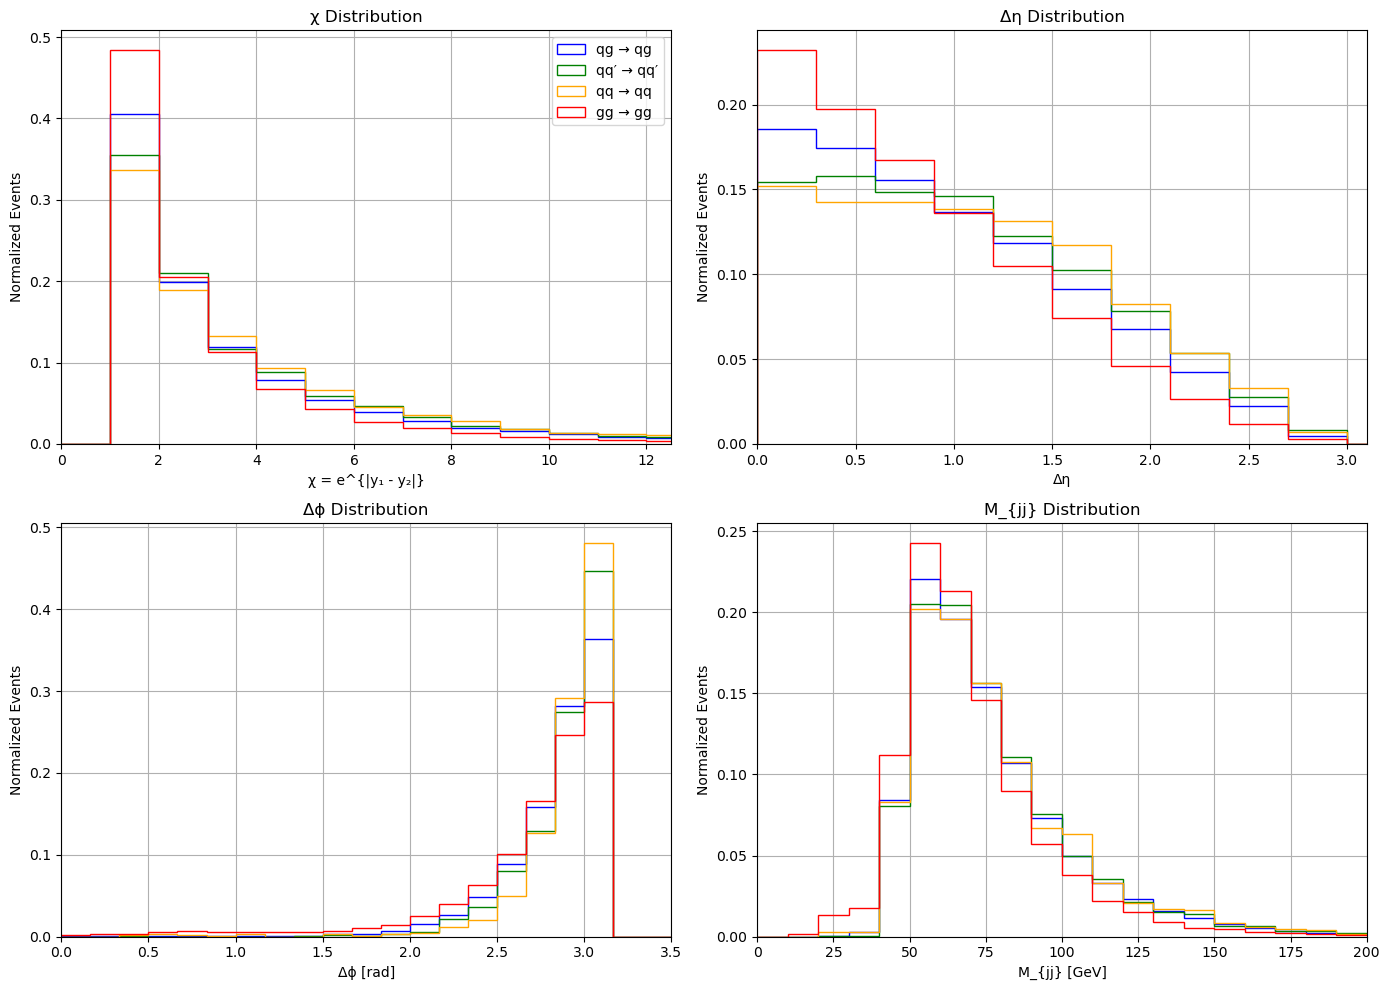

In [11]:
#Make cuts on d to have new dataframes with the different process -> parent types
d_qg_qg = d.Filter('process_type == "qg" && parent_type == "qg"')
d_qqp_qqp = d.Filter('process_type == "qqprime" && parent_type == "qqprime"')
d_qq_qq = d.Filter('process_type == "qq" && parent_type == "qq"')
d_gg_gg = d.Filter('process_type == "gg" && parent_type == "gg"')
d_gg_qqb = d.Filter('process_type == "gg" && parent_type == "qqbar"')
d_qqb_qqb = d.Filter('process_type == "qqbar" && parent_type == "qqbar"')

#Create histograms in root
h_qg_qg_chi  = d_qg_qg.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 50, 0, 50), "chi")
h_qqp_qqp_chi  = d_qqp_qqp.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 50, 0, 50), "chi")
h_qq_qq_chi  = d_qq_qq.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 50, 0, 50), "chi")
h_gg_gg_chi  = d_gg_gg.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 50, 0, 50), "chi")
h_gg_qqb_chi  = d_gg_qqb.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 50, 0, 50), "chi")
h_qqb_qqb_chi  = d_qqb_qqb.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 50, 0, 50), "chi")

h_qg_qg_phi = d_qg_qg.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 24, 0, 4), "DeltaPhi")
h_qqp_qqp_phi = d_qqp_qqp.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 24, 0, 4), "DeltaPhi")
h_qq_qq_phi = d_qq_qq.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 24, 0, 4), "DeltaPhi")
h_gg_gg_phi = d_gg_gg.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 24, 0, 4), "DeltaPhi")
h_gg_qqb_phi = d_gg_qqb.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 24, 0, 4), "DeltaPhi")
h_qqb_qqb_phi = d_qqb_qqb.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 24, 0, 4), "DeltaPhi")


h_qg_qg_eta = d_qg_qg.Histo1D(("h_deta", "Δη;Δη;Events", 20, 0, 6), "DeltaEta")
h_qqp_qqp_eta = d_qqp_qqp.Histo1D(("h_deta", "Δη;Δη;Events", 20, 0, 6), "DeltaEta")
h_qq_qq_eta = d_qq_qq.Histo1D(("h_deta", "Δη;Δη;Events", 20, 0, 6), "DeltaEta")
h_gg_gg_eta = d_gg_gg.Histo1D(("h_deta", "Δη;Δη;Events", 20, 0, 6), "DeltaEta")
h_gg_qqb_eta = d_gg_qqb.Histo1D(("h_deta", "Δη;Δη;Events", 20, 0, 6), "DeltaEta")
h_qqb_qqb_eta = d_qqb_qqb.Histo1D(("h_deta", "Δη;Δη;Events", 20, 0, 6), "DeltaEta")

h_qg_qg_mjj  = d_qg_qg.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 50, 0, 500), "Mjj")
h_qqp_qqp_mjj  = d_qqp_qqp.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 50, 0, 500), "Mjj")
h_qq_qq_mjj  = d_qq_qq.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 50, 0, 500), "Mjj")
h_gg_gg_mjj  = d_gg_gg.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 50, 0, 500), "Mjj")
h_gg_qqb_mjj  = d_gg_qqb.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 50, 0, 500), "Mjj")
h_qqb_qqb_mjj  = d_qqb_qqb.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 50, 0, 500), "Mjj")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Define plotting targets: (hist, axis, x_label, title, xlim)
plot_configs = [
    # χ
    ([h_qg_qg_chi, h_qqp_qqp_chi, h_qq_qq_chi, h_gg_gg_chi, h_gg_qqb_chi, h_qqb_qqb_chi],
     axs[0, 0], "χ = e^{|y₁ - y₂|}", "χ Distribution", (0, 12.5)),

    # Δη
    ([h_qg_qg_eta, h_qqp_qqp_eta, h_qq_qq_eta, h_gg_gg_eta, h_gg_qqb_eta, h_qqb_qqb_eta],
     axs[0, 1], "Δη", "Δη Distribution", (0, 3.1)),

    # Δϕ
    ([h_qg_qg_phi, h_qqp_qqp_phi, h_qq_qq_phi, h_gg_gg_phi, h_gg_qqb_phi, h_qqb_qqb_phi],
     axs[1, 0], "Δϕ [rad]", "Δϕ Distribution", (0, 3.5)),

    # Mjj
    ([h_qg_qg_mjj, h_qqp_qqp_mjj, h_qq_qq_mjj, h_gg_gg_mjj, h_gg_qqb_mjj, h_qqb_qqb_mjj],
     axs[1, 1], "M_{jj} [GeV]", "M_{jj} Distribution", (0, 200))
]

# Process type labels and colors
process_info = [
    ("qg → qg", "blue"),
    ("qq′ → qq′", "green"),
    ("qq → qq", "orange"),
    ("gg → gg", "red"),
    #("qq̄ → qq̄", "gray"),
    #("gg → qq̄", "magenta")
    
]

# Loop over each subplot
for (hist_list, ax, xlabel, title, xlim) in plot_configs:
    for h, (label, color) in zip(hist_list, process_info):
        edges, values = root_hist_to_numpy(h, normalize=True)
        ax.hist(edges[:-1], bins=edges, weights=values, histtype='step', label=label, linewidth=1, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Normalized Events")
    ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.grid(True)

axs[0, 0].legend(loc='upper right')  # One legend is enough

plt.tight_layout()
plt.savefig("dijet_distributions_by_process.png")
plt.show()


In [13]:
qg_qg_val   = d_qg_qg.Count().GetValue()
qqp_qqp_val = d_qqp_qqp.Count().GetValue()
qq_qq_val   = d_qq_qq.Count().GetValue()
gg_gg_val   = d_gg_gg.Count().GetValue()
gg_qqb_val  = d_gg_qqb.Count().GetValue()
qqb_qqb_val = d_qqb_qqb.Count().GetValue()

# Compute total and percentages
total = qg_qg_val + qqp_qqp_val + qq_qq_val + gg_gg_val + gg_qqb_val + qqb_qqb_val

# Print results
print(f"qg_qg   : {qg_qg_val} ({100 * qg_qg_val / total:.2f}%)")
print(f"qqp_qqp : {qqp_qqp_val} ({100 * qqp_qqp_val / total:.2f}%)")
print(f"qq_qq   : {qq_qq_val} ({100 * qq_qq_val / total:.2f}%)")
print(f"gg_gg   : {gg_gg_val} ({100 * gg_gg_val / total:.2f}%)")
print(f"gg_qqb  : {gg_qqb_val} ({100 * gg_qqb_val / total:.2f}%)")
print(f"qqb_qqb : {qqb_qqb_val} ({100 * qqb_qqb_val / total:.2f}%)")
print(f"Total   : {total}")

qg_qg   : 598374 (25.37%)
qqp_qqp : 201668 (8.55%)
qq_qq   : 56265 (2.39%)
gg_gg   : 1458369 (61.82%)
gg_qqb  : 31632 (1.34%)
qqb_qqb : 12737 (0.54%)
Total   : 2359045


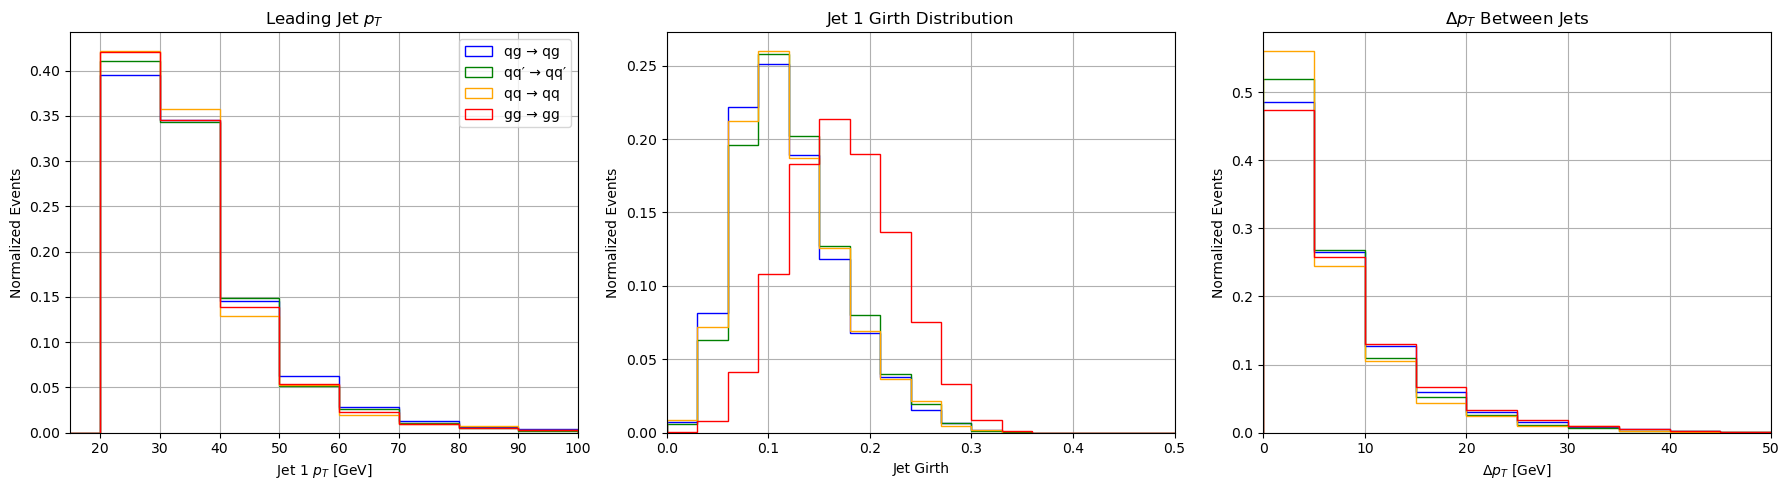

In [12]:
#Create more histograms in root
h_qg_qg_pt1  = d_qg_qg.Histo1D(("h_pt1", "Jet 1 PT; PT ;Events", 10, 0, 100), "jet1_pt")
h_qqp_qqp_pt1  = d_qqp_qqp.Histo1D(("h_pt1", "Jet 1 PT; PT ;Events", 10, 0, 100), "jet1_pt")
h_qq_qq_pt1  = d_qq_qq.Histo1D(("h_pt1", "Jet 1 PT; PT ;Events", 10, 0, 100), "jet1_pt")
h_gg_gg_pt1  = d_gg_gg.Histo1D(("h_pt1", "Jet 1 PT; PT ;Events", 10, 0, 100), "jet1_pt")
h_gg_qqb_pt1  = d_gg_qqb.Histo1D(("h_pt1", "Jet 1 PT; PT ;Events", 10, 0, 100), "jet1_pt")
h_qqb_qqb_pt1  = d_qqb_qqb.Histo1D(("h_pt1", "Jet 1 PT; PT ;Events", 10, 0, 100), "jet1_pt")

# Jet 1 Girth
h_qg_qg_girth = d_qg_qg.Histo1D(("h_girth", "Jet 1 Girth; Girth; Events", 20, 0, 0.6), "jet1_girth")
h_qqp_qqp_girth = d_qqp_qqp.Histo1D(("h_girth", "Jet 1 Girth; Girth; Events", 20, 0, 0.6), "jet1_girth")
h_qq_qq_girth = d_qq_qq.Histo1D(("h_girth", "Jet 1 Girth; Girth; Events", 20, 0, 0.6), "jet1_girth")
h_gg_gg_girth = d_gg_gg.Histo1D(("h_girth", "Jet 1 Girth; Girth; Events", 20, 0, 0.6), "jet1_girth")
h_gg_qqb_girth = d_gg_qqb.Histo1D(("h_girth", "Jet 1 Girth; Girth; Events", 20, 0, 0.6), "jet1_girth")
h_qqb_qqb_girth = d_qqb_qqb.Histo1D(("h_girth", "Jet 1 Girth; Girth; Events", 20, 0, 0.6), "jet1_girth")

# Delta PT
h_qg_qg_dpt = d_qg_qg.Histo1D(("h_dpt", "Δp_T;|p_{T1} - p_{T2}|;Events", 10, 0, 50), "DeltaPT")
h_qqp_qqp_dpt = d_qqp_qqp.Histo1D(("h_dpt", "Δp_T;|p_{T1} - p_{T2}|;Events", 10, 0, 50), "DeltaPT")
h_qq_qq_dpt = d_qq_qq.Histo1D(("h_dpt", "Δp_T;|p_{T1} - p_{T2}|;Events", 10, 0, 50), "DeltaPT")
h_gg_gg_dpt = d_gg_gg.Histo1D(("h_dpt", "Δp_T;|p_{T1} - p_{T2}|;Events", 10, 0, 50), "DeltaPT")
h_gg_qqb_dpt = d_gg_qqb.Histo1D(("h_dpt", "Δp_T;|p_{T1} - p_{T2}|;Events", 10, 0, 50), "DeltaPT")
h_qqb_qqb_dpt = d_qqb_qqb.Histo1D(("h_dpt", "Δp_T;|p_{T1} - p_{T2}|;Events", 10, 0, 50), "DeltaPT")


# Extend plot_configs list
plot_configs += [

    # Jet 1 PT
    ([h_qg_qg_pt1, h_qqp_qqp_pt1, h_qq_qq_pt1, h_gg_gg_pt1, h_gg_qqb_pt1, h_qqb_qqb_pt1],
     None, "Jet 1 $p_T$ [GeV]", "Leading Jet $p_T$", (15, 100)),

    # Jet 1 Girth
    ([h_qg_qg_girth, h_qqp_qqp_girth, h_qq_qq_girth, h_gg_gg_girth, h_gg_qqb_girth, h_qqb_qqb_girth],
     None, "Jet Girth", "Jet 1 Girth Distribution", (0, 0.5)),

    # Delta PT
    ([h_qg_qg_dpt, h_qqp_qqp_dpt, h_qq_qq_dpt, h_gg_gg_dpt, h_gg_qqb_dpt, h_qqb_qqb_dpt],
     None, r"$\Delta p_T$ [GeV]", "Δ$p_T$ Between Jets", (0, 50))
]

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))

# Reassign axes for those 3 plots
for i in range(3):
    plot_configs[-3 + i] = (plot_configs[-3 + i][0], axs2[i], *plot_configs[-3 + i][2:])

# Plot them
for (hist_list, ax, xlabel, title, xlim) in plot_configs[-3:]:
    for h, (label, color) in zip(hist_list, process_info):
        edges, values = root_hist_to_numpy(h, normalize=True)
        ax.hist(edges[:-1], bins=edges, weights=values, histtype='step', label=label, linewidth=1, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Normalized Events")
    ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.grid(True)

axs2[0].legend(loc='upper right')
plt.tight_layout()
plt.savefig("dijet_additional_distributions.png")
plt.show()